### To Do for B.5 -
1. Implement a function that solves the multistep prediction problem to allow the prediction to
be made for a sequence of closing prices of k days into the future.
2. Implement a function that solve the simple multivariate prediction problem to that takes into
account the other features, for the same company (including opening price, highest price,
lowest price, closing price, adjusted closing price, trading volume) as the input for predicting the
closing price of the company for a specified day in the future.
3. Combine the above two function to solve the multivariate, multistep prediction problem.

### Imports

In [1125]:
import mplfinance as flpt
from bqplot import pyplot as plt
import bqplot as bq
from collections import deque

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
import tensorflow as tf
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, InputLayer, Bidirectional, Input, SimpleRNN, GRU
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

import yfinance as yf

import time


### Setting Data Parameters

In [1126]:
COMPANY_TICKER = "AMZN"

# Specification of start and end date for both train and test sets
# This means that at some point we need to split the dataset
START_DATE = '2019-01-01'
END_DATE = '2024-01-01'

NAN_HANDLER = "drop" # Determines how NaN data is handled. Can be "drop", "fill_mean", "fill_median", or "fill_ffill"

TEST_SIZE = 0.20 # e.g. this would be that 75% of the available data is being used for the train set and 25% is being used for the test set.

# If false the data will be randomly split
SPLIT_BY_DATE = True

# ["Open", "Adj Close", "Volume", "High", "Close", "Low"] 

FEATURE_COLUMN = ["Open", "Adj Close", "Volume", "High", "Close", "Low"]  # Can be set to "Adj Close", "Volume", "Open", "High", or "Low"

# Scalar is used to normalize data to a specific range (In this code, it normalizes the data to between 0 and 1)
SCALE = True

DATE_NOW = time.strftime("%Y-%m-%d")


In [1127]:
N_LAYERS = 2
# Type of recurrent unit
CELL = SimpleRNN
# Amount of neurons per laye
UNITS = 256
# 40% dropout
DROPOUT = 0.4
# whether to use bidirectional
BIDIRECTIONAL = False

LOSS = "mae"
OPTIMIZER = "adam"
BATCH_SIZE = 64
EPOCHS = 200

N_STEPS = 120 # How many days of past data the model uses to make a prediction
LOOKUP_STEP = 120 # How far into the future the model is predicting


### Loading Data from Yahoo Finance or Local File

In [1128]:
def load_or_save_data(company_ticker, start_date, end_date, base_dir="data"):
    ###
    # Loads the dataset for the input company and range.
    # If the dataset is not available locally, it downloads the data and saves it as a CSV file.
    # Parameters:
    # - company_ticker: ticker of the company (e.g., "AMZN")
    # - start_date: the start date for the dataset in 'YYYY-MM-DD' format
    # - end_date: the end date for the dataset in 'YYYY-MM-DD' format
    # - base_dir: the base directory where the data will be saved, default is set to "data"
    # Returns:
    # - data: pandas DF, the loaded dataset with the specified features
    ###

    # Generate the save path based on ticker and date range
    filename = f"{company_ticker}_{start_date}_to_{end_date}.csv"
    save_path = os.path.join(base_dir, filename)
    
    # Check if the file already exists
    if os.path.exists(save_path):
        # Load the dataset from the local file
        data = pd.read_csv(save_path, index_col=0, parse_dates=True)
        print(f"Data loaded from local file: {save_path}")
    else:
        # If the file doesn't exist, download the data
        data = yf.download(company_ticker, start=start_date, end=end_date)
        
        # Make sure the base directory exisxts
        os.makedirs(base_dir, exist_ok=True)
        
        # Save the dataset locally
        data.to_csv(save_path)
        print(f"Data downloaded and saved locally to: {save_path}")
    
    return data

### Handling NaN values in dataset

In [1129]:
def handle_nan(data, method='drop'):
    ###
    # Handles NaN values in the dataset based on the specified method.
    # Parameters:
    # - data: pandas Dataframe
    # - method: str, how to handle NaN values. Options are 'drop', 'fill_mean', 'fill_median', 'fill_ffill'.
    # Drop removes all NaN data from the dataset.
    # Mean replaces the NaN data with the mean average of all the data 
    # Mediam replaces the NaN data with the median average of all the data 
    # FFill sets the NaN data to the most recent valid data
    # Returns:
    # - data: pandas Dataframe, the dataset with NaN values handled
    ###


    if method == 'drop':
        data = data.dropna()
    elif method == 'fill_mean':
        data = data.fillna(data.mean())
    elif method == 'fill_median':
        data = data.fillna(data.median())
    elif method == 'fill_ffill':
        data = data.fillna(method='ffill')
    else:
        raise ValueError("Choose from 'drop', 'fill_mean', 'fill_median', 'fill_ffill'.")
    
    return data

### Splitting Data

In [1130]:
def split_data(data, test_size=0.25, split_by_date=True, date_column='Date'):

    ###
    # Splits the dataset into training and testing sets based on the specified methods.
    # Parameters:
    # - data: pandas datadframe, the dataset to split
    # - test_size: float, the amount of the dataset to include in the test split (default is 0.25)
    # - split_by_date: bool, split the data by date (True) or randomly (False). If false, the data is split using sklearns train_test_split method
    # - date_column: str, the name of the date column to use for date-based splitting (only needed if split_by_date=True)
    # Returns:
    # - train_data: training set as a pandas dataframe
    # - test_data: testing set as a pandas dataframe
    #
    #
    ###

    if split_by_date:
        # Sort data by date
        data = data.sort_values(by=date_column)
        
        # Determine the split index
        split_index = int(len(data) * (1 - test_size))
        
        # Split the data
        train_data = data.iloc[:split_index]
        test_data = data.iloc[split_index:]
    else:
        # Randomly split the data using sklearn's train_test_split
        train_data, test_data = train_test_split(data, test_size=test_size, shuffle=True, random_state=180)
    
    return train_data, test_data


### Scale Data

In [1131]:
from sklearn.preprocessing import MinMaxScaler

def scale_data(data, feature_columns):
    ###
    # Scales the specified feature columns in the dataset using MinMaxScaler and stores the scalers.
    # Parameters:
    # - data: pandas dataframe, the dataset to scale
    # - feature_columns: list, a list of feature columns to scale (e.g., ["Adj Close"])
    # Returns:
    # - scaled_data: pandas dataframe, the dataset with scaled feature columns
    # - scalers: dict, a dictionary of scalers used to scale the feature columns
    ###
    scalers = {}
    scaled_data = data.copy()
    
    # scale data in specified feature columns
    for feature in feature_columns:
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data[feature] = scaler.fit_transform(scaled_data[[feature]])
        scalers[feature] = scaler  # Store the scaler for future access
    
    return scaled_data, scalers

In [1132]:
def create_sequences(data, n_steps):
    sequences = deque(maxlen=n_steps)
    sequence_data = []
    
    for entry in data:
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append(np.array(sequences))
    
    return np.array(sequence_data)

### Using functionalities with parameters

In [1133]:
# Load the data
data = load_or_save_data(COMPANY_TICKER, START_DATE, END_DATE)

# Handle NaNs
data = handle_nan(data, NAN_HANDLER)

# Split the data
train_data, test_data = split_data(data, TEST_SIZE, SPLIT_BY_DATE)

# Scale the data if true
if SCALE:
    train_data, scalers = scale_data(train_data, FEATURE_COLUMN)
    test_data, _ = scale_data(test_data, FEATURE_COLUMN)  # Extract the scaled data, discard the scaler for test


print(train_data.head())

# sequences using N_STEPS and LOOKUP_STEP for training and testing
X_train = create_sequences(train_data[FEATURE_COLUMN].values, N_STEPS)
X_test = create_sequences(test_data[FEATURE_COLUMN].values, N_STEPS)

# Shift the target to get future stock prices based on LOOKUP_STEP
y_train = train_data[FEATURE_COLUMN[0]].shift(-LOOKUP_STEP).dropna().values
y_test = test_data[FEATURE_COLUMN[0]].shift(-LOOKUP_STEP).dropna().values

# Make sure shapes match between sequences and targets
X_train, y_train = X_train[:len(y_train)], y_train[:len(X_train)]
X_test, y_test = X_test[:len(y_test)], y_test[:len(X_test)]


Data loaded from local file: data/AMZN_2019-01-01_to_2024-01-01.csv
                Open      High       Low     Close  Adj Close    Volume
Date                                                                   
2019-01-02  0.000000  0.006872  0.000000  0.017413   0.017413  0.483576
2019-01-03  0.024052  0.000000  0.016182  0.000000   0.000000  0.414973
2019-01-04  0.028436  0.025055  0.025663  0.033665   0.033665  0.565253
2019-01-07  0.060168  0.043202  0.057365  0.057921   0.057921  0.484264
2019-01-08  0.087542  0.062016  0.069629  0.070054   0.070054  0.544743


### Data Aggregation

In [1134]:
def aggregate_data(data, n_days=1):
    if n_days > 1:
        data_resampled = data.resample(f'{n_days}D').agg({
            'Open': 'first', # Set open to be the first data point of this set
            'High': 'max', # Set high to be the higehst data point of this set
            'Low': 'min', # Set low to be the lowest data point of this set
            'Close': 'last', # Set close to be the last data point of this set
            'Adj Close': 'last', # Set adj close to be the last data point of this set
            'Volume': 'sum' # Set volume to be the sum of all data points in this set
        })
    else:
        data_resampled = data
    return data_resampled

### Candlestick Chart
(using mplfinance)

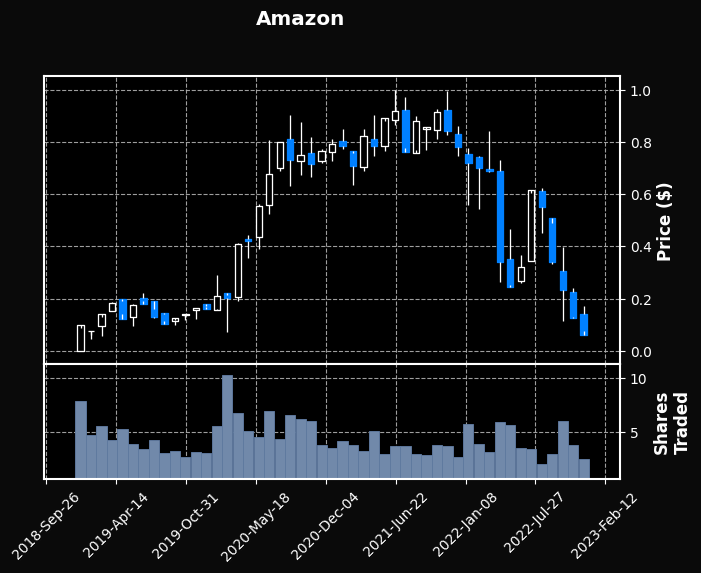

In [1135]:
###
# Plots a candlestick chart according to the parameters
# Parameters:
# - data: the dataset to plot
# - volume: Bool to determine if secondary chart is plotted below main candlestick chart
# - show_nontrading: Bool to determine if NaN days are shown
# - title: String for the title of the chart
# - n_days: How many days each candlestick represents, default is 1
###

def plot_candlestick_chart(data, volume, show_nontrading, title, n_days=1):
    new_data = aggregate_data(data, n_days)

    flpt.plot(
        new_data,
        type="candle", # Type of chart
        volume=volume,
        show_nontrading=show_nontrading,
        title=title,
        style="mike", # Visual style of chart
        ylabel='Price ($)', # Y candle chart Label
        ylabel_lower="Shares\nTraded" # Y secondary chart label
    )

plot_candlestick_chart(train_data, True, True, "Amazon", 30)


### Boxplot
(using pyplot from BQ)

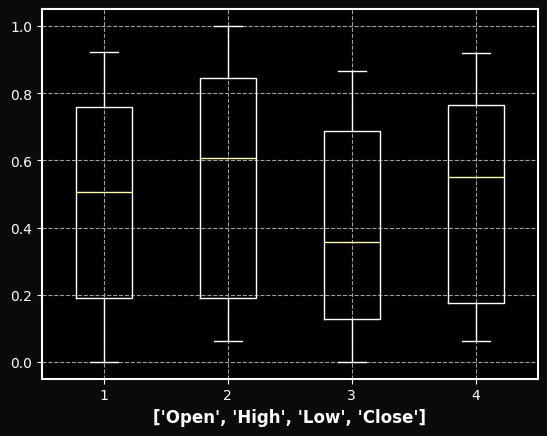

In [1136]:
###
# Plots a boxplot chart according to the parameters
# Parameters:
# - data: pandas dataframe, the dataset to plot
# - features: Each feature to be plotted as a string in a list
# - n_days: How many days each candlestick represents, default is 1
###

### Why not just do all features?
# If we do, the volume values dwarf the other values
# Therefore we should only do it for the non volume features
# Scaling them is also typically not good for box plots

def plot_boxplot_chart(data, features, n_days=1):
    new_data = aggregate_data(data, n_days)

    # Extract the data for the selected features
    box_data = [new_data[feature] for feature in features]

    # Create figure
    fig = plt.figure()

    # Create box plots for each feature
    plt.boxplot(box_data)

    # X axis labelss
    plt.xlabel(features)

    # Show the chart
    plt.show()

plot_boxplot_chart(train_data,["Open", "High", "Low", "Close"], 30)

### Machine Learning

Model Construction

In [1137]:
def create_model(sequence_length, n_features, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                 loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False):
    model = Sequential()
    
    # Add Input layer
    model.add(Input(shape=(sequence_length, n_features)))
    
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        
        # add dropout after each layer
        model.add(Dropout(dropout))
    
    # Output layer
    model.add(Dense(1, activation="linear"))
    
    # Compile the model
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    
    return model


model = create_model(N_STEPS, len(FEATURE_COLUMN), loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)

Model Training

In [1138]:
model_name = f"{DATE_NOW}_{COMPANY_TICKER}-{START_DATE}-{END_DATE}-{TEST_SIZE}-{NAN_HANDLER}\
{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-layers-{N_LAYERS}-units-{UNITS}"
if BIDIRECTIONAL:
    model_name += "-b"

checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".weights.h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))

history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_test, y_test),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)



Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.9219 - mean_absolute_error: 0.9219
Epoch 1: val_loss improved from inf to 0.05275, saving model to results/2024-09-11_AMZN-2019-01-01-2024-01-01-0.2-dropmae-adam-SimpleRNN-seq-layers-2-units-256.weights.h5
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - loss: 0.9135 - mean_absolute_error: 0.9135 - val_loss: 0.0528 - val_mean_absolute_error: 0.0528
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.7003 - mean_absolute_error: 0.7003
Epoch 2: val_loss did not improve from 0.05275
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - loss: 0.7019 - mean_absolute_error: 0.7019 - val_loss: 0.4220 - val_mean_absolute_error: 0.4220
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.7513 - mean_absolute_error: 0.7513
Epoch 3: val_loss did not improve from 0.05275
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - loss: 0.7517 - mean_absolute_error: 0.7517 - val_loss: 0.3693 - val_mean_absolute_error: 0.3693
Epoch 4/200
14/14 ━━━━━━

### Model Testing

In [ ]:
def plot_graph(test_df, LOOKUP_STEP):
    plt.plot(test_df[f'true_adjclose_{LOOKUP_STEP}'], c='b')
    plt.plot(test_df[f'adjclose_{LOOKUP_STEP}'], c='r')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()

In [ ]:
def get_final_df(model, X_test, y_test, test_df, scalers, LOOKUP_STEP, SCALE):
    # copy of the test DataFrame to avoid the SettingWithCopyWarning
    test_df = test_df.copy()

    # Perform prediction
    y_pred = model.predict(X_test)

    # Inverse scale if needed
    if SCALE:
        y_test = np.squeeze(scalers["Adj Close"].inverse_transform(np.expand_dims(y_test, axis=0)))
        y_pred = np.squeeze(scalers["Adj Close"].inverse_transform(y_pred))
        test_df["Adj Close"] = scalers["Adj Close"].inverse_transform(test_df[["Adj Close"]])  # Inverse scale current price

    # check that the lengths of y_pred and test_df match
    test_df = test_df.iloc[-len(y_pred):]

    # Add predictions and true values to the test dataframe 
    test_df.loc[:, f"adjclose_{LOOKUP_STEP}"] = y_pred
    test_df.loc[:, f"true_adjclose_{LOOKUP_STEP}"] = y_test[-len(y_pred):]
    
    # Sort the dataframe by date to ensure correct alignment
    test_df.sort_index(inplace=True)

    # Define profit calculation lambdas
    buy_profit  = lambda current, pred_future, true_future: true_future - current if pred_future > current else 0
    sell_profit = lambda current, pred_future, true_future: current - true_future if pred_future < current else 0

    # Calculate buy and sell profits 
    test_df.loc[:, "buy_profit"] = list(map(buy_profit, test_df["Adj Close"], test_df[f"adjclose_{LOOKUP_STEP}"], test_df[f"true_adjclose_{LOOKUP_STEP}"]))
    test_df.loc[:, "sell_profit"] = list(map(sell_profit, test_df["Adj Close"], test_df[f"adjclose_{LOOKUP_STEP}"], test_df[f"true_adjclose_{LOOKUP_STEP}"]))

    # Handle the last sequence where profit cannot be calculated
    test_df.loc[:, "buy_profit"] = test_df["buy_profit"].fillna(0)
    test_df.loc[:, "sell_profit"] = test_df["sell_profit"].fillna(0)

    return test_df

In [1139]:
def predict_future_price(model, last_sequence, scalers, N_STEPS, SCALE):
    # Ensure last_sequence has the right shape (N_STEPS, features)
    last_sequence = np.expand_dims(last_sequence, axis=0)
    
    # Make the prediction
    prediction = model.predict(last_sequence)
    
    # Inverse scale the prediction if scaling was applied
    if SCALE:
        predicted_price = scalers["Adj Close"].inverse_transform(prediction)[0][0]
    else:
        predicted_price = prediction[0][0]
    
    return predicted_price


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Loss: 0.0910729169845581
Mean Absolute Error: 0.0910729169845581
Accuracy Score: 0.5303030303030303
Total Buy Profit: -7.97847766635428
Total Sell Profit: 40.80331337790088
Total Profit: 32.8248357115466
Profit Per Trade: 0.24867299781474694
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predicted future price after 120 days: 174.80$


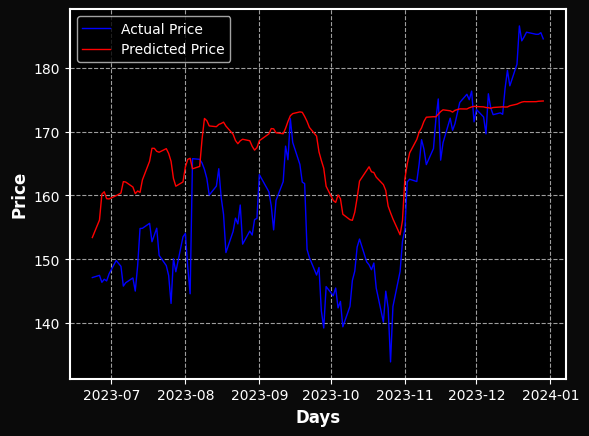

In [1140]:
final_df = get_final_df(model, X_test, y_test, test_data, scalers, LOOKUP_STEP, SCALE)

loss, mae = model.evaluate(X_test, y_test, verbose=0)

mean_absolute_error = mae

# Calculate the accuracy score (based on positive buy/sell profits)
accuracy_score = (len(final_df[final_df['sell_profit'] > 0]) + len(final_df[final_df['buy_profit'] > 0])) / len(final_df)

# Calculate total profits
total_buy_profit  = final_df["buy_profit"].sum()
total_sell_profit = final_df["sell_profit"].sum()
total_profit = total_buy_profit + total_sell_profit
profit_per_trade = total_profit / len(final_df)

print(f"Loss: {loss}")
print(f"Mean Absolute Error: {mean_absolute_error}")
print(f"Accuracy Score: {accuracy_score}")
print(f"Total Buy Profit: {total_buy_profit}")
print(f"Total Sell Profit: {total_sell_profit}")
print(f"Total Profit: {total_profit}")
print(f"Profit Per Trade: {profit_per_trade}")

last_sequence = X_test[-1]

# Predict the future price
future_price = predict_future_price(model, last_sequence, scalers, N_STEPS, SCALE)

print(f"Predicted future price after {LOOKUP_STEP} days: {future_price:.2f}$")

plot_graph(final_df, LOOKUP_STEP)